# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

**(Generated with the assistance of AI – please interpret code and results with caution.)**

This notebook introduces and demonstrates how to explore [Dandiset 001174](https://dandiarchive.org/dandiset/001174/0.250331.2218):

- Calcium imaging data from miniscope recordings in supplementary motor area (SMA) and primary motor cortex (M1) in rhesus macaques.
- Neuronal activity recorded during rest or arm-reaching tasks.
- Data are stored in NWB format, organized by subject and session, with segmentation and fluorescence data ready for reanalysis.

## Notebook Overview

This notebook will help you:
- Access and browse data assets using the DANDI API.
- Explore the structure and principal data objects of the NWB files.
- Visualize the imaging field-of-view, cell segmentation masks (ROIs), and example calcium traces.
- Inspect and analyze segmentation mask information via pandas DataFrames.
- Suggest next steps for reanalysis and batch processing.

**Required Packages**  
- `numpy`
- `matplotlib`
- `h5py`
- `remfile`
- `pandas`
- `dandi` (for DandiAPIClient)

Please ensure these are installed before running the notebook.

## 1. Connecting to DANDI: Listing NWB Assets

We'll use the DANDI API to programmatically access metadata and file paths for Dandiset 001174. This allows you to browse session data and select files for analysis (no full file download required).

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Connect to the DANDI API and access the specific Dandiset version
dandiset_id = "001174"
dandiset_version = "0.250331.2218"
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB file assets
assets = list(islice(dandiset.get_assets_by_glob("*.nwb"), 10))
print("First 10 NWB files in Dandiset 001174:")
for asset in assets:
    print(f"Path: {asset.path}\tSize (MB): {asset.size / 1e6:.2f}")

First 10 NWB files in Dandiset 001174:
Path: sub-V/sub-V_ses-20230309T110929_ophys.nwb	Size (MB): 10659.71
Path: sub-Q/sub-Q_ophys.nwb	Size (MB): 790.14
Path: sub-Q/sub-Q_ses-20220922T131747_ophys.nwb	Size (MB): 787.85
Path: sub-Q/sub-Q_ses-20221003T131952_ophys.nwb	Size (MB): 1695.93
Path: sub-Q/sub-Q_ses-20221028T121142_ophys.nwb	Size (MB): 1557.21
Path: sub-Q/sub-Q_ses-20221201T132256_ophys.nwb	Size (MB): 1656.99
Path: sub-Q/sub-Q_ses-20221202T122907_ophys.nwb	Size (MB): 1568.85
Path: sub-Q/sub-Q_ses-20221206T121002_ophys.nwb	Size (MB): 25117.05
Path: sub-Q/sub-Q_ses-20220915T133954_ophys.nwb	Size (MB): 1178.27
Path: sub-Q/sub-Q_ses-20221201T134628_ophys.nwb	Size (MB): 835.45


## 2. File and Data Structure Overview

Each subject (e.g., `sub-Q`, `sub-V`) has multiple sessions, which are stored as individual NWB files. These NWB files typically contain:

- **Raw Imaging Movies**: Large time-series movies from one-photon miniscope imaging (`/acquisition/OnePhotonSeries/data`).
- **Segmented ROIs**: Spatial masks identifying individual neurons (`/processing/ophys/ImageSegmentation/PlaneSegmentation/image_mask`).
- **ROI Fluorescence Traces**: Calcium activity for each ROI/cell over time (`/processing/ophys/Fluorescence/RoiResponseSeries/data`).
- **Event Amplitude Data**: Optionally, event amplitudes for detected neural events.
- **Metadata**: Information on device, imaging plane, subject, and session timing.

## 3. Loading NWB Data via Remote Streaming

For interactive exploration, we recommend working with one file at a time and streaming only the data of interest rather than downloading large files.

Below, we connect to a representative NWB file (`sub-Q/sub-Q_ses-20221206T121002_ophys.nwb`) using `remfile` and `h5py`. All data exploration and visualization will use remote streaming.

In [2]:
import h5py
import remfile

# Select one representative session for exploration
example_asset_path = 'sub-Q/sub-Q_ses-20221206T121002_ophys.nwb'
example_asset = next(dandiset.get_assets_by_glob(example_asset_path))
url = example_asset.download_url

# Open the remote NWB file for reading (read-only, random access)
remote_file = remfile.File(url)
f = h5py.File(remote_file, 'r')

# Print structure of main groups for orientation
print("Top-level NWB groups:", list(f.keys()))
print("Processing modules:", list(f['processing'].keys()))
print("Acquisition data:", list(f['acquisition'].keys()))

Top-level NWB groups: ['acquisition', 'analysis', 'file_create_date', 'general', 'identifier', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time']


Processing modules: ['ophys']
Acquisition data: ['OnePhotonSeries']


## 4. Visualizing the Imaging Field of View (Mean Projection)

To get a sense of the recorded area, let's display a mean projection over the imaging movie. To keep things quick and light, we'll average across 20 evenly spaced frames.

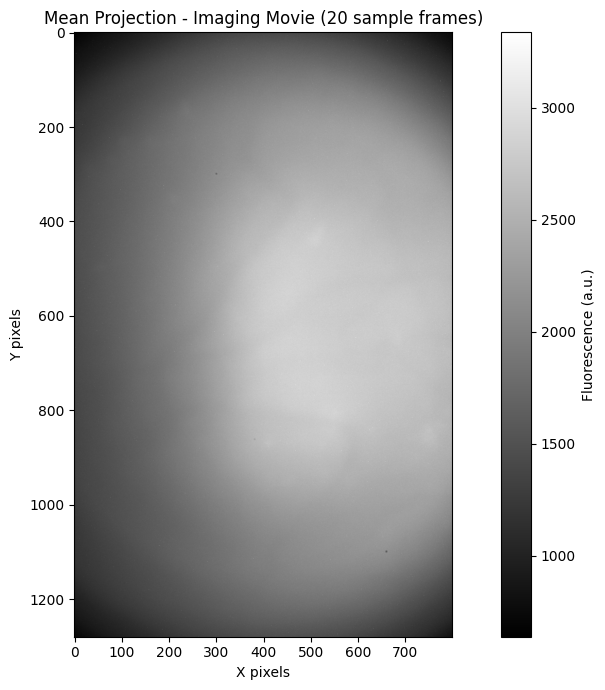

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Access the imaging movie dataset
dset = f['/acquisition/OnePhotonSeries/data']
n_frames = dset.shape[0]
num_samples = 20  # Use 20 sample frames for summary
sample_idxs = np.linspace(0, n_frames - 1, num_samples, dtype=int)
frames = np.stack([dset[i, :, :] for i in sample_idxs])
mean_img = frames.mean(axis=0)

plt.figure(figsize=(10, 7))
plt.imshow(mean_img, cmap='gray')
plt.title('Mean Projection - Imaging Movie (20 sample frames)')
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.colorbar(label='Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

**Interpretation:**  
The above projection provides an overview of the miniscope's field of view for this session. 
Darker and lighter regions reflect structure in the tissue and/or illumination differences.  
Segmented ROIs (cells) will be superimposed on this view in the next step.

## 5. Overlaying ROI Masks (Cell Footprints)

Now we'll visualize how automated segmentation identified individual neurons. The following plot overlays up to 10 cell masks on the mean imaging projection.

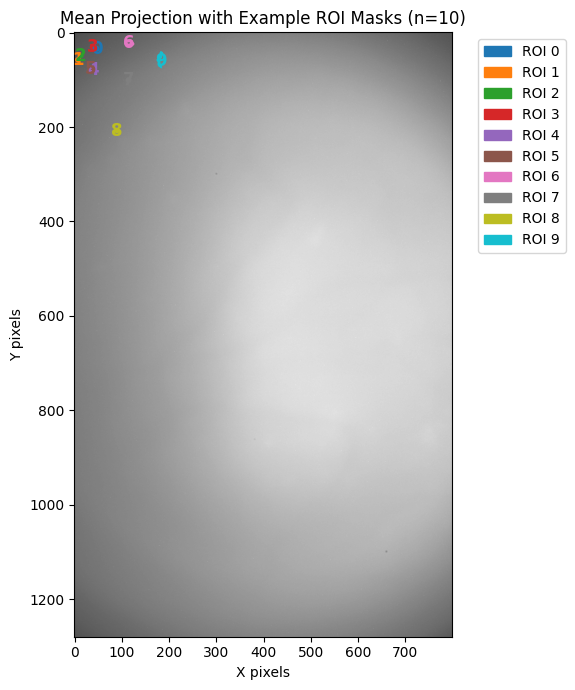

In [4]:
import matplotlib.patches as mpatches

# Access segmented masks (ImageSegmentation PlaneSegmentation)
ps = f['processing/ophys/ImageSegmentation/PlaneSegmentation']
image_masks = ps['image_mask']
num_rois = image_masks.shape[0]

# Plot mean projection with up to 10 ROI masks overlaid
max_display = min(10, num_rois)
plt.figure(figsize=(10, 7))
plt.imshow(mean_img, cmap='gray', alpha=0.7)
colors = plt.cm.tab10.colors
for idx in range(max_display):
    mask = image_masks[idx]
    # Plot mask contour where mask > 0.5
    plt.contour(mask, levels=[0.5], colors=[colors[idx % 10]], linewidths=2)
    y, x = np.where(mask > 0.5)
    if len(x) > 0 and len(y) > 0:
        plt.text(x.mean(), y.mean(), str(idx), color=colors[idx % 10], fontsize=12,
                 ha='center', va='center', weight='bold')
patches = [mpatches.Patch(color=colors[i % 10], label=f'ROI {i}') for i in range(max_display)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'Mean Projection with Example ROI Masks (n={max_display})')
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.tight_layout()
plt.show()

**Interpretation:**  
Colored contours show how up to 10 cells were identified and extracted from the field of view. These correspond directly to the fluorescence traces shown in the next section.

## 6. Plotting Fluorescence Traces for Segmented ROIs

Let's look at the calcium activity from these segmented neurons. Below, we plot the fluorescence traces for up to 10 ROIs, vertically offset for clarity.

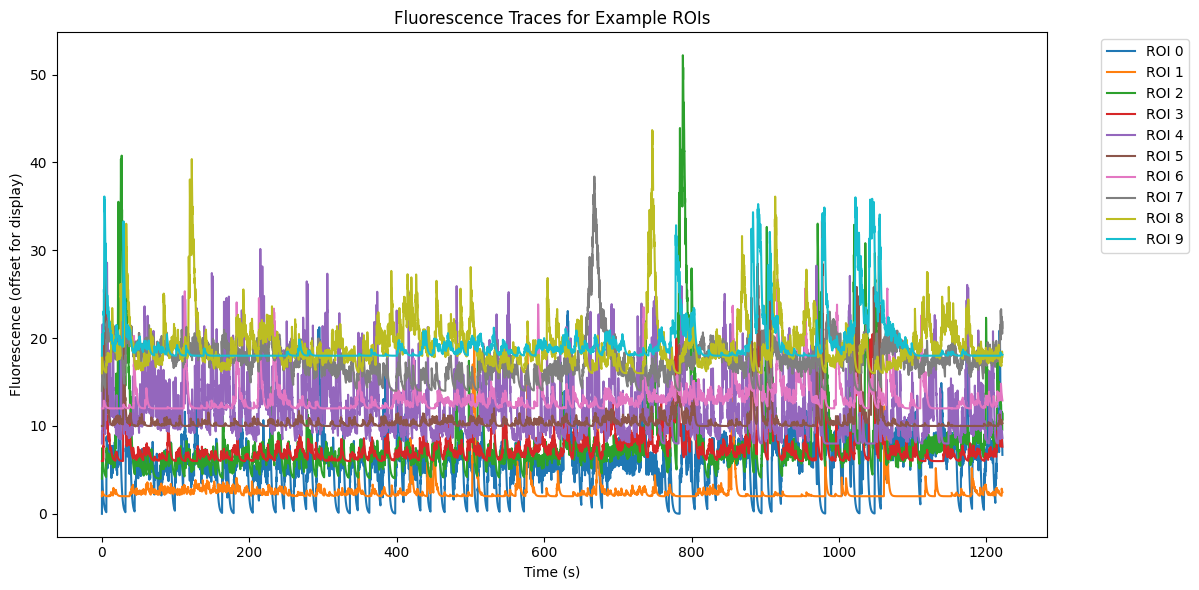

In [5]:
# Load fluorescence (dF/F) traces for all ROIs
fluor = f['processing/ophys/Fluorescence/RoiResponseSeries/data']
time_points, n_rois = fluor.shape

# Build time axis (imaging rate ~10 Hz)
sample_rate = 10.0
T = time_points / sample_rate
time = np.linspace(0, T, time_points)

max_display = min(10, n_rois)
offset = 2  # vertical offset for clarity
plt.figure(figsize=(12, 6))
for i in range(max_display):
    plt.plot(time, fluor[:, i] + offset * i, color=colors[i % 10], label=f'ROI {i}')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (offset for display)')
plt.title('Fluorescence Traces for Example ROIs')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

**Interpretation:**  
Each line shows the calcium activity of an individual cell (ROI) across the session.  
Large events (peaks) indicate calcium transients, which may correspond to bursts of action potentials.

## 7. Analyzing Segmentation Properties as a DataFrame

It's often useful to analyze and export segmentation features (such as ROI/cell area) for quality control or downstream analysis. The script below illustrates how to summarize this information in a pandas DataFrame.

In [6]:
import pandas as pd

# Compute area (pixels) for each segment's mask
image_masks = ps['image_mask'][:]
roi_areas = np.sum(image_masks > 0.5, axis=(1, 2))
roi_df = pd.DataFrame({
    'roi_index': np.arange(num_rois),
    'area_pixels': roi_areas
})

print(roi_df.head())
print(f'Total ROIs in this session: {num_rois}')
print(f'Average cell footprint area (pixels): {roi_areas.mean():.1f} ± {roi_areas.std():.1f}')

   roi_index  area_pixels
0          0           29
1          1           19
2          2           29
3          3           54
4          4           26
Total ROIs in this session: 18
Average cell footprint area (pixels): 53.6 ± 35.8


**Interpretation & Use:**  
- Each 'roi_index' corresponds to a segment/cell.  
- 'area_pixels' reflects the number of pixels in the mask (footprint area).  
- Example uses: filter out very small/large ROIs, batch compare across sessions, link feature size to signal quality.

You can also merge this table with functional data (like activity, peak amplitude, etc.) for richer analyses.

## 8. Recommendations & Next Steps for Reanalysis

You're now equipped to:
- Access NWB data assets and their structure programmatically via the DANDI API.
- Visualize the field of view, segmentation, and fluorescence data.
- Export segmentation and timeseries data for further analysis.

**Ideas for Further Analysis:**
- Batch process multiple files, merge segment tables, and compare across sessions or subjects.
- Align neural activity to behavioral events (if available).
- Calculate correlations between neuron/cell activity.
- Filter or classify ROIs based on spatial and activity metrics.

For more advanced analyses, consult:
- [NWB Documentation](https://pynwb.readthedocs.io/en/stable/)
- [DANDI Tutorials](https://tutorials.dandiarchive.org/)
- [Neurosift browser](https://neurosift.app/nwb?dandisetId=001174&dandisetVersion=0.250331.2218&path=sub-Q/sub-Q_ses-20221206T121002_ophys.nwb) for visual NWB exploration

---

**End of notebook.**  
_Questions or improvements? Please consider updating and sharing with the DANDI community!_